In [244]:
# CONSTANTS

# Binance takes a 0.1% fee on each transaction (buy or sell).
# Fee stucture documented on: https://www.binance.com/en/fee/trading
FEE_MULTIPLIER = 0.999

# Given the fee structure, for a buy/sell pair to be profitable, the buy price divided by
# sell price needs to be greater that 1001/999 = 1.002002

# Setting PROFIT_RATIO = 1.25 results in a lot better performance, as it sells for higher profit
# when applying RSI 80/40 strategy
PROFIT_RATIO = 1.3

In [297]:
import numpy as np
import talib
import matplotlib.pyplot as plt
import datetime

# function to apply epoch->human readable datetime for a numpy array
# unix_to_datetime = np.vectorize(datetime.datetime.fromtimestamp)

# load and plot 5 minute candle data from May 2021

# raw_data = np.genfromtxt('5_minute_klines_max.csv', delimiter=',')
raw_data = np.genfromtxt('5m_2021_data.csv', delimiter=',')
# raw_data = np.genfromtxt('ETHGBP-5m-2021-06.csv', delimiter=',')
# raw_data = np.genfromtxt('june 2021/june.csv', delimiter=',')

closing_prices = raw_data[:, 4]
rsi = talib.RSI(closing_prices, timeperiod=14)
timestamps = [datetime.datetime.fromtimestamp(epoch_times).strftime("%m/%d/%Y, %H:%M:%S") for epoch_times in raw_data[:, 0]/1000]

In [358]:
# read daily closing prices and compute RSI based on them
import json
  
f = open('2021_daily_data/2021_data.json',)
daily_data = np.array(json.load(f))
f.close()

daily_close_prices = daily_data[:, 4].astype(float)
daily_rsi = talib.RSI(daily_close_prices, timeperiod=14)

timestamped_daily_rsi = dict(zip(daily_data[:, 0], daily_rsi))
timestamped_daily_rsi

{'1609459200000': nan,
 '1609545600000': nan,
 '1609632000000': nan,
 '1609718400000': nan,
 '1609804800000': nan,
 '1609891200000': nan,
 '1609977600000': nan,
 '1610064000000': nan,
 '1610150400000': nan,
 '1610236800000': nan,
 '1610323200000': nan,
 '1610409600000': nan,
 '1610496000000': nan,
 '1610582400000': nan,
 '1610668800000': 71.43379376974697,
 '1610755200000': 73.0495405611805,
 '1610841600000': 73.18209344913241,
 '1610928000000': 73.87556337629451,
 '1611014400000': 76.84984592069145,
 '1611100800000': 76.91212277350644,
 '1611187200000': 58.09463080948256,
 '1611273600000': 62.682144134245455,
 '1611360000000': 62.73334844373938,
 '1611446400000': 67.84605864846243,
 '1611532800000': 63.557821014000794,
 '1611619200000': 64.81848387588315,
 '1611705600000': 58.07530727005308,
 '1611792000000': 61.30030992994765,
 '1611878400000': 63.07592465723783,
 '1611964800000': 63.04916201706921,
 '1612051200000': 59.06813356818459,
 '1612137600000': 61.560680534203314,
 '16122240

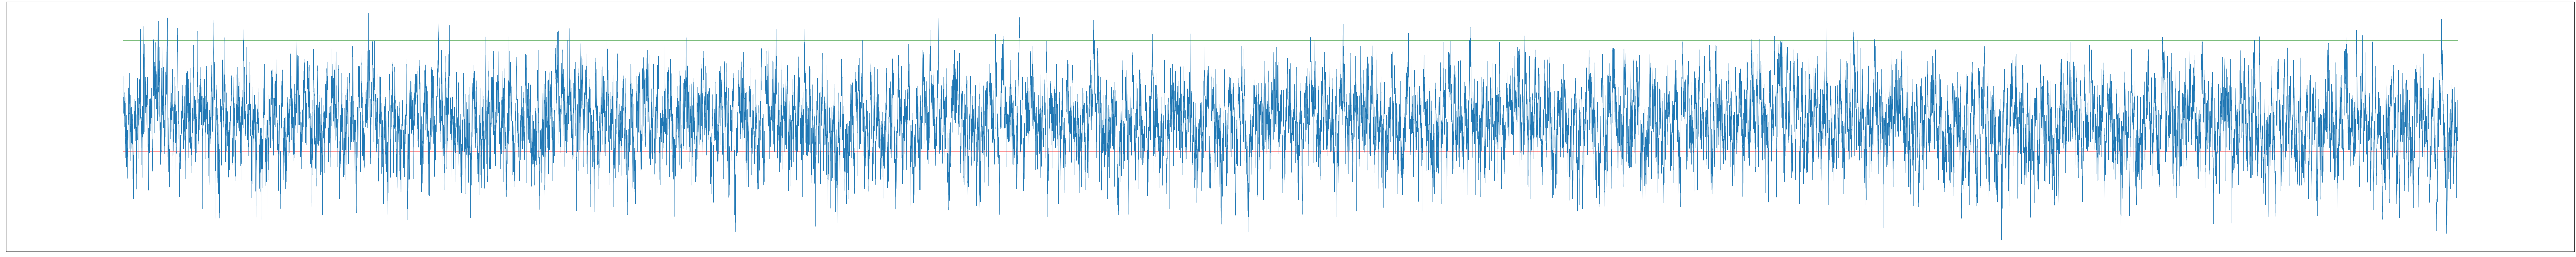

In [280]:
# plot 5 minute RSI and oversold/overbought lines as 40/80
def plot_rsi():
    fig, ax = plt.subplots(figsize=(200, 20))
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    frequency = 1000
    plt.plot(timestamps, rsi)
    plt.xticks(timestamps[::frequency])
    plt.hlines(y = 80, xmin = 0, xmax = rsi.size, color="g")
    plt.hlines(y = 40, xmin = 0, xmax = rsi.size, color="r")
    plt.show()

plot_rsi()

In [302]:
# util functions for buy/sell and profit calculation
buys = []
sells = []

def reset_trades():
    buys = []
    sells = []

def print_trades():
    for i in range(len(sells)):
        print(f'buy at {buys[i]}; sell at {sells[i]}')
    
def buy(fiat_amount, crypto_price):
    buys.append(crypto_price)
    effective_amount = fiat_amount * FEE_MULTIPLIER
    print(f'buy at {crypto_price}')
    return effective_amount / crypto_price

def sell(crypto_amount, crypto_price):
    sells.append(crypto_price)
    effective_amount = crypto_amount * FEE_MULTIPLIER
    print(f'sell at {crypto_price}')
    return effective_amount * crypto_price

def make_profit(buy_price, current_price):
    if current_price == 0:
        return False
    return current_price / buy_price > PROFIT_RATIO

def hold_profit(start_amount, closing_prices):
    print(f'Hold strategy result if buying at {closing_prices[0]} and holding until {closing_prices[-1]} is {start_amount * closing_prices[-1] / closing_prices[0]}')

In [378]:
# My take on the standard RSI trading strategy. 
# Based on current findings, it outperforms simply holding

def run_simulation(starting_sum, rsi, close_prices, overbought_signal, oversold_signal):
    current_sum = starting_sum
    crypto_held = 0
    buy_price = 0
    
    for idx, x in np.ndenumerate(rsi):
        if not np.isnan(x) and close_prices[idx] != 0:
            if x < oversold_signal and current_sum != 0:
                buy_price = close_prices[idx]
                crypto_held = buy(current_sum, close_prices[idx])
                current_sum = 0
            if x > overbought_signal and crypto_held != 0 and make_profit(buy_price, close_prices[idx]):
                current_sum = sell(crypto_held, close_prices[idx])
                crypto_held = 0
#                 print(f'fiat amount at after transactions: {current_sum}')

    if (current_sum == 0):
        print(f'Holding bags! Crypto amount at end of month: {crypto_held} valued at close of {close_prices[-1]} as {crypto_held * close_prices[-1]}.')
    else:
        print(f'fiat amount at end of month: {current_sum}')
        
reset_trades()
run_simulation(100, rsi, closing_prices, 80, 40)
hold_profit(100, closing_prices)
# print_trades()

buy at 543.36
sell at 791.23
buy at 773.45
sell at 1057.4
buy at 1027.43
sell at 1380.21
buy at 1361.63
sell at 2056.48
buy at 2059.03
sell at 2848.11
buy at 2769.97
Holding bags! Crypto amount at end of month: 0.19948940671307297 valued at close of 1357.26 as 270.75899215538544.
Hold strategy result if buying at 540.63 and holding until 1357.26 is 251.05155096831476


In [410]:
# Conceptually, it might be worth not always buying (i.e. in a very overbought market) 
# and not always selling (i.e. in a very oversold market).

# By using the daily RSI data, this can achieve a stop loss strategy. 
# So far, all experiments have underperformed the standard RSI strategy from above
RSI_DROP_DELTA = 20

'''
Use RSI 80/40 strategy based on 5 minute data, only when the daily RSI value 
is within a safety margin 
'''
def rsi_with_daily_data(starting_sum, ts_5min_rsi, ts_daily_rsi, close_prices, 
                        overbought_signal, oversold_signal):
    current_sum = starting_sum
    crypto_held = 0
    buy_price = 0
    
    idx = 0
    daily_idx = 0
    daily_timestamps = np.array(list(timestamped_daily_rsi.keys())).astype(int) 
    
    for i in ts_daily_rsi:
        if np.isnan(ts_daily_rsi[i]):
            ts_daily_rsi[i] = 101
    
    last_buy_date = -1
    last_panic_sale = -1
    
    for ts in ts_5min_rsi:
        while ts > daily_timestamps[daily_idx]:
            daily_idx += 1
        
        if not np.isnan(ts_5min_rsi[ts]) and close_prices[idx] != 0:
            if buy_conditions(daily_idx, ts, ts_5min_rsi, oversold_signal, current_sum, last_panic_sale):
                buy_price = close_prices[idx]
                print(f'buy at rsi of {ts_daily_rsi[str(daily_timestamps[daily_idx])]} daily_idx={daily_idx}')
                crypto_held = buy(current_sum, close_prices[idx])
                last_buy_date = daily_idx
                current_sum = 0
            if sell_conditions(ts_5min_rsi, ts, overbought_signal, crypto_held, buy_price, close_prices, idx):
                current_sum = sell(crypto_held, close_prices[idx])
                crypto_held = 0
                
            # if there has been a sudden day over day drop in RSI, the market might be moving down, so sell
            if daily_idx > 0 and crypto_held != 0 \
            and ts_daily_rsi[str(daily_timestamps[daily_idx - 1])] - ts_daily_rsi[str(daily_timestamps[daily_idx])] > RSI_DROP_DELTA \
            and ts_daily_rsi[str(daily_timestamps[daily_idx - 1])] != 101 \
            and last_buy_date != daily_idx:
                print(f'Emergency sell! {daily_idx} RSI dropped from {ts_daily_rsi[str(daily_timestamps[daily_idx - 1])]} to {ts_daily_rsi[str(daily_timestamps[daily_idx])]}')
                current_sum = sell(crypto_held, close_prices[idx])
                crypto_held = 0
                last_panic_sale = daily_idx
        idx += 1

    if (current_sum == 0):
        print(f'Holding bags! Crypto amount at end of month: {crypto_held} valued at close of {close_prices[-1]} as {crypto_held * close_prices[-1]}.')
    else:
        print(f'fiat amount at end of month: {current_sum}')
        
def buy_conditions(daily_idx, ts, ts_5min_rsi, oversold_signal, current_sum, last_panic_sale):
    return daily_idx > 0 and ts_5min_rsi[ts] < oversold_signal and current_sum != 0 and last_panic_sale != daily_idx

def sell_conditions(ts_5min_rsi, ts, overbought_signal, crypto_held, buy_price, close_prices, idx):
    return ts_5min_rsi[ts] > overbought_signal and crypto_held != 0 and make_profit(buy_price, close_prices[idx])

reset_trades()
ts_5min_rsi = dict(zip(raw_data[:, 0], rsi))
rsi_with_daily_data(100, ts_5min_rsi, timestamped_daily_rsi, closing_prices, 80, 40)
hold_profit(100, closing_prices)

buy at rsi of 101 daily_idx=1
buy at 543.36
sell at 791.23
buy at rsi of 101 daily_idx=4
buy at 773.45
sell at 1057.4
buy at rsi of 76.91212277350644 daily_idx=19
buy at 1027.43
sell at 1380.21
buy at rsi of 70.44485820920386 daily_idx=49
buy at 1361.63
sell at 2056.48
buy at rsi of 74.5108713838498 daily_idx=121
buy at 2059.03
sell at 2848.11
buy at rsi of 79.83343421421601 daily_idx=129
buy at 2769.97
Holding bags! Crypto amount at end of month: 0.19948940671307297 valued at close of 1357.26 as 270.75899215538544.
Hold strategy result if buying at 540.63 and holding until 1357.26 is 251.05155096831476


In [426]:
'''
This approach tries to improve on the standard RSI variation by dollar cost averaging the buy/sell 
into multiple trades over a set number of klines (dollar cost averaging)

SEEMS TO YIELD BETTER RESULTS THAN VANILLA RSI 80/40 for DCA splitting into 2, 3 and 4 (with best results at 4)

Need to investigate 
'''
def run_dca_simulation(starting_sum, rsi, close_prices, 
                       overbought_signal, oversold_signal, explosion_count):
    current_sum = starting_sum
    crypto_held = 0
    buy_price = 0
    chunk_size = current_sum / explosion_count

    idx = 0
    while idx < rsi.size:
        r = rsi[idx]
        if not np.isnan(r) and close_prices[idx] != 0:
            while rsi[idx] < oversold_signal and current_sum > 0:
                buy_price = close_prices[idx]
                crypto_held += buy(chunk_size, close_prices[idx])
                current_sum -= chunk_size
                idx += 1
            
            if r > overbought_signal and crypto_held != 0 and make_profit(buy_price, close_prices[idx]):
                current_sum += sell(crypto_held, close_prices[idx])
                crypto_held = 0
                chunk_size = current_sum / explosion_count
        
        idx += 1

    if (current_sum == 0):
        print(f'Holding bags!!!!\nCrypto amount at end of month: {crypto_held} valued at {crypto_held * close_prices[-1]}')
    else:
        print(f'fiat amount at end of month: {current_sum}')

reset_trades()
run_improved_simulation(100, rsi, closing_prices, 80, 40, 4)
hold_profit(100, closing_prices)
# print_trades()

buy at 543.36
buy at 543.16
buy at 543.16
buy at 543.16
sell at 791.23
buy at 773.45
buy at 756.54
buy at 747.24
buy at 733.99
buy at 744.22
sell at 969.99
buy at 962.69
buy at 963.82
buy at 959.61
buy at 1027.43
buy at 1033.45
sell at 1380.21
buy at 1361.63
buy at 1362.37
buy at 1361.49
buy at 1366.23
sell at 2056.48
buy at 2059.03
buy at 2046.56
buy at 2051.24
buy at 2051.85
buy at 2049.16
sell at 2848.11
buy at 2769.97
buy at 2769.14
buy at 2765.95
buy at 2770.35
Holding bags!!!!
Crypto amount at end of month: 0.23779652869859727 valued at 322.7517165414581
Hold strategy result if buying at 540.63 and holding until 1357.26 is 251.05155096831476
